# Skin Lesion Risk Identification
### Utilization of Skin Lesion Images to Build a Malignancy Risk Classifier

## Table of Contents

* <a href='#Part_1'> Obtain</a>
* <a href='#Part_2'> Data Scrubbing & Exploration</a> 
* <a href='#Part_4'> Model</a> 
* <a href='#Part_5'> Final Model</a>
* <a href='#Part_6'> Conclusions</a>
* <a href='#Part_7'> Recommendations & Future Work</a>



In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import itertools
import shutil
import pydot
import os
import keras
import keras_metrics  
import matplotlib.pyplot as plt
import tensorflow
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from keras import backend as K
from keras.utils import plot_model
from keras.layers import Dropout,GlobalMaxPooling2D
from keras import layers, models, regularizers, optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import MobileNet, MobileNetV2, VGG19
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

from glob import glob

%matplotlib inline


Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("          Normalized confusion matrix")
    else:
        print("     Confusion matrix, without normalization")

    

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def classification_report_graph(model):
    acc = model.history['acc']
    val_acc = model.history['val_acc']
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    rec = model.history['recall']
    val_rec = model.history['val_recall']
    f1 = model.history['f1_score']
    val_f1 = model.history['val_f1_score']
    prec = model.history['precision']
    val_prec = model.history['val_precision']
    epochs = range(len(acc))
    plt.figure(figsize=(15,10))
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ob-', label='Validation Accuracy')
    plt.legend()
    plt.figure(figsize=(15,10))
    plt.plot(epochs, loss, 'g', label='Training Loss')
    plt.plot(epochs, val_loss, 'og-', label='Validation Loss')
    plt.title('Training and Validation Accuracy/Loss')
    plt.legend()
    plt.figure(figsize=(15,10))
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ob-', label='Validation Accuracy')
    plt.plot(epochs, rec, 'c', label='Training Recall Score')
    plt.plot(epochs, val_rec, 'oc-', label='Validation Recall Score')
    plt.plot(epochs, f1, 'g', label='Training F1 Score')
    plt.plot(epochs, val_f1, 'og-', label='Validation F1 Score')
    plt.plot(epochs, prec, 'r', label='Training Precision Score')
    plt.plot(epochs, val_prec, 'or-', label='Validation Precision Score')
    plt.title('Training and Validation Recall/Precision/F1 Score')
    plt.legend()
    plt.show()

    
def model_report(model, test_data, weights=None):
    if weights is None:
        predictions= model.predict_classes(test_data, batch_size=None)
        report= classification_report(test_data.classes,predictions,target_names=list(test_data.class_indices.keys()))
        cm= confusion_matrix(test_data.classes, predictions)
        print(report, '\n\n')  
        plot_confusion_matrix(cm, list(test_data.class_indices.keys()), normalize=True)
    else:
        model.load_weights(weights)
        predictions= model.predict_classes(test_data, batch_size=None)
        report= classification_report(test_data.classes,predictions,target_names=list(test_data.class_indices.keys()))
        cm= confusion_matrix(test_data.classes, predictions)
        print(report, '\n\n')  
        plot_confusion_matrix(cm, list(test_data.class_indices.keys()), normalize=True)

In [3]:
#creating directories
base_directory = 'base_directory'
os.mkdir(base_directory)
#training directory:
train_directory = os.path.join(base_directory, 'train_directory')
os.mkdir(train_directory)
#testing directory:
test_directory = os.path.join(base_directory, 'test_directory')
os.mkdir(test_directory)
#splitting training directory for bening/malignant images:
low_risk = os.path.join(train_directory, 'low_risk')
os.mkdir(low_risk)
severe_risk = os.path.join(train_directory, 'severe_risk')
os.mkdir(severe_risk)

#splitting testing directory for bening/malignant images:
low_risk = os.path.join(test_directory, 'low_risk')
os.mkdir(low_risk)
severe_risk = os.path.join(test_directory, 'severe_risk')
os.mkdir(severe_risk)


<a id='Part_1'></a>

# Obtaining our Data:

In [4]:
#importing the dataframe
df = pd.read_csv('../Project-4-Neural-Networks-For-Skin-Cancer-Risk-Assessment/HAM10000_metadata.tab', 
                 delimiter='\t')

In [5]:
#brief first look at the data
print(df.shape)
df.head()

(10015, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


<a id='Part_2'></a>

# Data Scrubbing and Exploration:

In [6]:
#preparing separate dataframe to group by lesion to identify lesions w/multiple images
df1 = df.groupby('lesion_id').count()
df1 = df1[df1['image_id'] == 1]
df1.reset_index(inplace=True)
df1.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [7]:
#identifying and removing duplicates:
def duplicates(x):
    lesion_list = list(df1['lesion_id'])
    if x in lesion_list:
        return 'no_duplicates'
    else:
        return 'duplicate'
    
# create a new colum that is a copy of the lesion_id column
df['duplicate'] = df['lesion_id']
# apply the function to this new column
df['duplicate'] = df['duplicate'].apply(duplicates)
df = df[df['duplicate'] == 'no_duplicates']
df.shape

(5514, 8)

In [8]:
#classifying lesion types as benign vs malignant
df['dx'] = df['dx'].map({'nv':    'low_risk', 
                         'bkl':   'low_risk', 
                         'vasc':  'low_risk', 
                         'df':    'low_risk', 
                         'mel':   'severe_risk', 
                         'bcc':   'severe_risk', 
                         'akiec': 'severe_risk'})

In [9]:
#splitting the data for train/test
y = df['dx']
_, df_val = train_test_split(df, test_size=0.25, stratify=y)
df_val.shape

(1379, 8)

In [10]:
# Examining class imbalance
df_val['dx'].value_counts()

low_risk       1240
severe_risk     139
Name: dx, dtype: int64

In [11]:
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'
# identify train and val rows
# create a new colum that is a copy of the image_id column
df['train_or_val'] = df['image_id']
# apply the function to this new column
df['train_or_val'] = df['train_or_val'].apply(identify_val_rows)
# filter out train rows
df_train = df[df['train_or_val'] == 'train']
#setting image id as the index
df.set_index('image_id', inplace=True)
print(len(df_train))
print(len(df_val))

4135
1379


### Moving images into train/test directories

In [12]:
# connecting to the image directory folders
folder_1 = os.listdir('../Project-4-Neural-Networks-For-Skin-Cancer-Risk-Assessment/HAM10000_images_part_1/')
folder_2 = os.listdir('../Project-4-Neural-Networks-For-Skin-Cancer-Risk-Assessment/HAM10000_images_part_2/')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

# Transfer the train images:
for image in train_list:
    fname = image + '.jpg'
    label = df.loc[image,'dx']
    if fname in folder_1:
        # source path to image
        src = os.path.join(
            '../Project-4-Neural-Networks-For-Skin-Cancer-Risk-Assessment/HAM10000_images_part_1/', fname)
        # destination path to image
        dst = os.path.join(train_directory, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    if fname in folder_2:
        # source path to image
        src = os.path.join(
            '../Project-4-Neural-Networks-For-Skin-Cancer-Risk-Assessment/HAM10000_images_part_2/', fname)
        # destination path to image
        dst = os.path.join(train_directory, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

#transfer the val images:        
for image in val_list:
    fname = image + '.jpg'
    label = df.loc[image,'dx']
    if fname in folder_1:
        # source path to image
        src = os.path.join(
            '../Project-4-Neural-Networks-For-Skin-Cancer-Risk-Assessment/HAM10000_images_part_1/', fname)
        # destination path to image
        dst = os.path.join(test_directory, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    if fname in folder_2:
        # source path to image
        src = os.path.join(
            '../Project-4-Neural-Networks-For-Skin-Cancer-Risk-Assessment/HAM10000_images_part_2/', fname)
        # destination path to image
        dst = os.path.join(test_directory, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)     

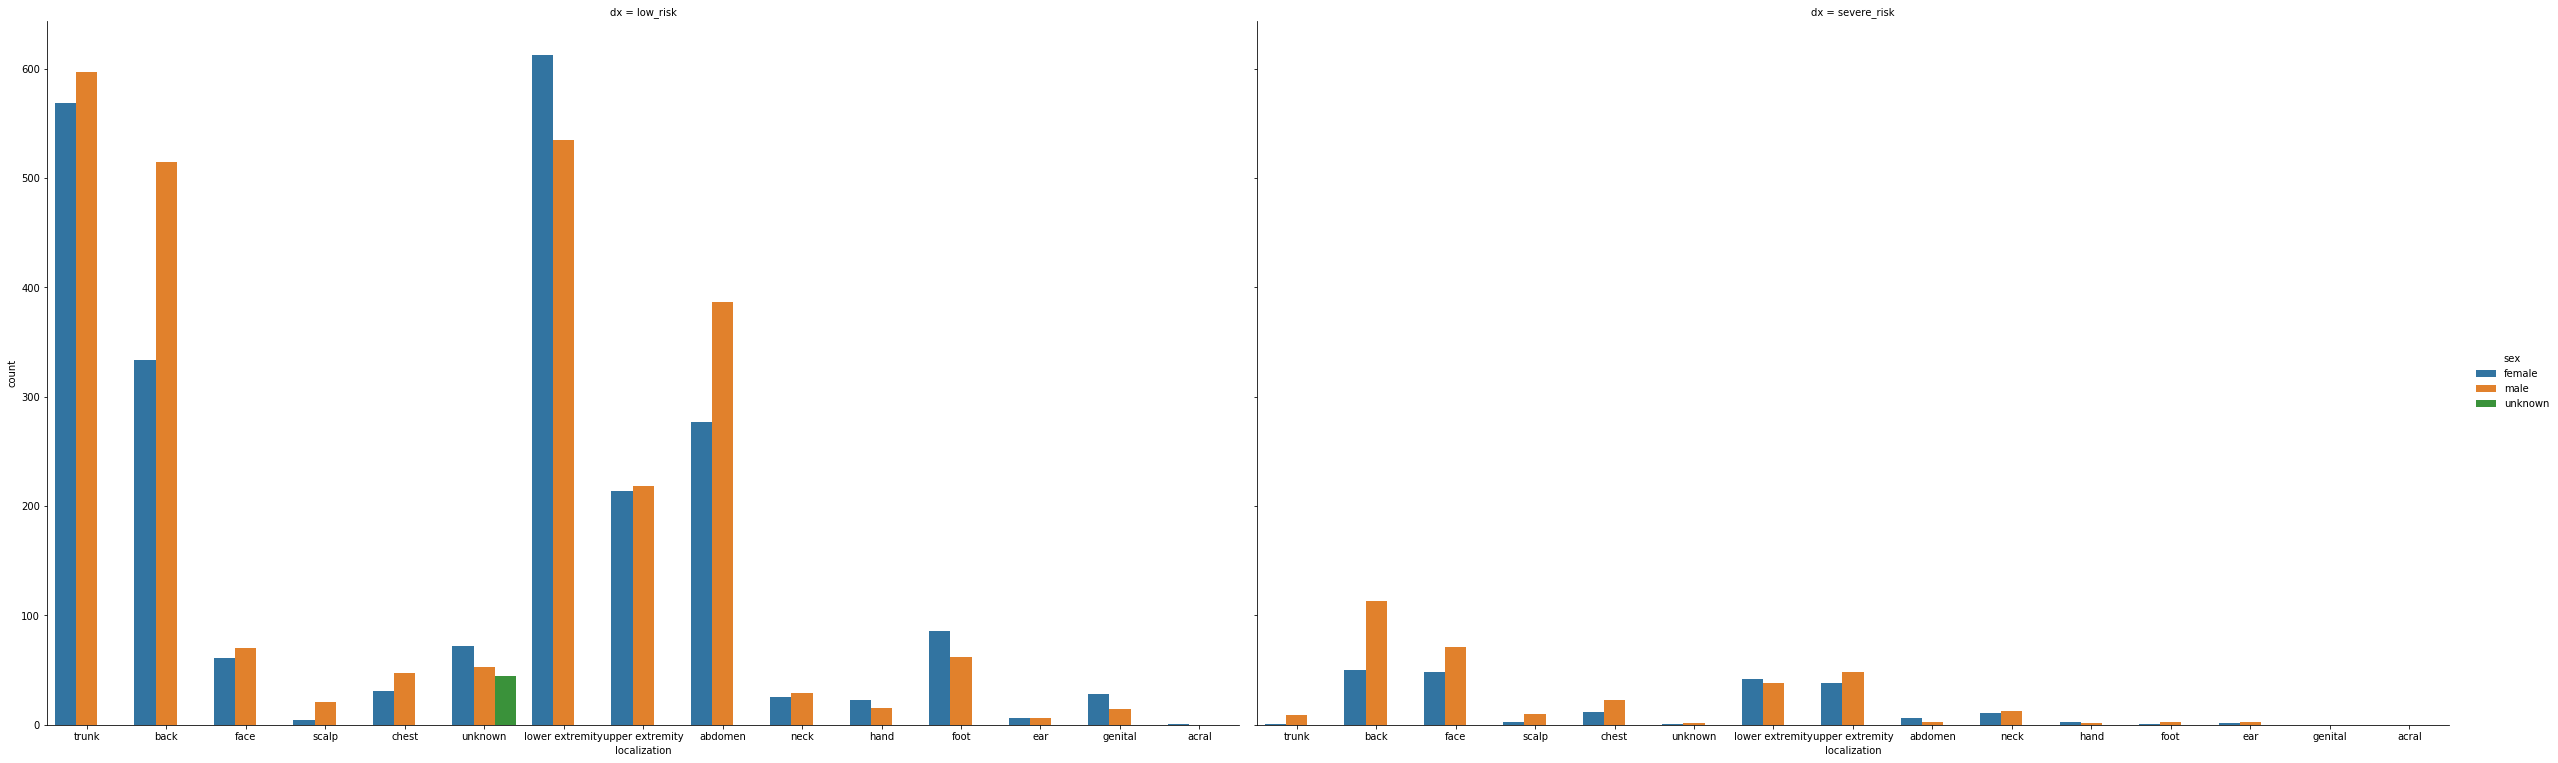

In [13]:
# Examining the distribution of categorical variables in the dataset 
sns.catplot(x="localization", hue="sex", col="dx", data=df, kind="count", 
            height=10.7, aspect=1.6, sharex=True, sharey=True);

We see that more men are reporting benign lesions as well as having malignant lesions discovered, consistent with risk factor data

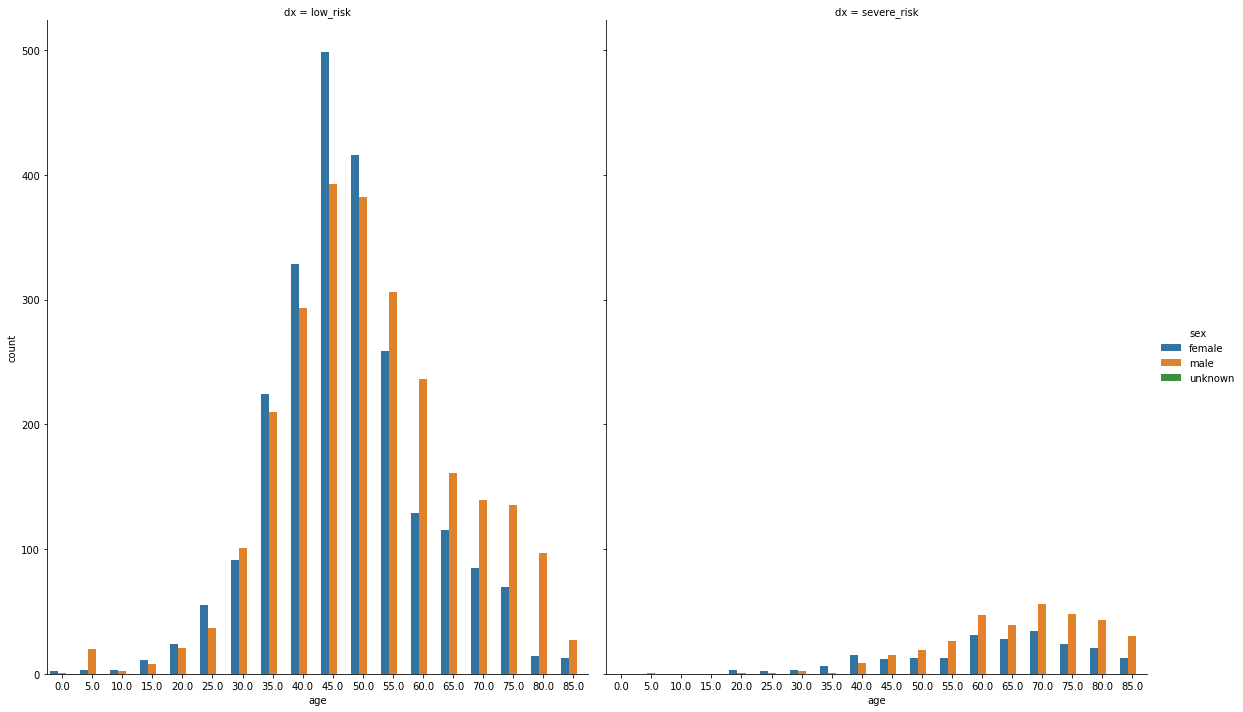

In [14]:
sns.catplot(x="age", hue="sex", col="dx", data=df, kind="count", 
                height=10, aspect=0.8, sharex=True, sharey=True);

It looks like younger women are at a higher risk compared to younger men, and as age increases, men become more at risk of having a malignant lesion.

### Utilizing ImageDataGenerator for Image Preprocessing to prepare for modeling:

In [15]:
# Generating batches of tensor image data
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=.10)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_directory, subset= "training",shuffle=True,
                                                    target_size=(72,72),batch_size=128,
                                                    class_mode='binary')

validation_generator = train_datagen.flow_from_directory(train_directory, subset="validation",shuffle=True,
                                                         target_size=(72,72),batch_size=128,
                                                         class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_directory,target_size=(72,72),
                                                  shuffle=False,batch_size=1,
                                                  class_mode='binary')
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 

test_generator.class_indices

Found 3723 images belonging to 2 classes.
Found 412 images belonging to 2 classes.
Found 1379 images belonging to 2 classes.


{'low_risk': 0, 'severe_risk': 1}

In [16]:
# utilizing class weights to address class imbalance
weight = class_weight.compute_class_weight('balanced',np.unique(y), y)
class_weights = {0:weight[0], 1:weight[1]}
class_weights

{0: 0.5560709963695039, 1: 4.9586330935251794}

<a id='Part_4'></a>

# Modeling our Data:

### Model 1: CNN Built from Scratch:

In [17]:
#assembling the model architecture
model1 = models.Sequential() 
model1.add(layers.Conv2D(256, (6, 6), activation='relu', input_shape=(72,72, 3)))

model1.add(layers.Conv2D(128, (4, 4), activation='relu'))

model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(64, (3, 3), activation='relu'))

model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Flatten())

model1.add(layers.Dense(512, activation='relu'))

model1.add(layers.Dropout(0.25))

model1.add(layers.Dense(256, activation='relu'))

model1.add(layers.Dropout(0.2))

model1.add(layers.Dense(128, activation='relu'))

model1.add(layers.Dropout(0.15))

model1.add(layers.Dense(64, activation='relu'))

model1.add(layers.Dense(1, activation='sigmoid'))

model1.save('model_1.h5') #saving the model
model1.save('model_3.h5') #saving an additional copy for future use with augmented data

filepath = 'Model_1_Weights/weights.{epoch:02d}.hdf5' #saving the weights at each epoch to find/use optimal model
os.mkdir('Model_1_Weights')
checkpoint = ModelCheckpoint(filepath, verbose=0, save_weights_only=True)

#compiling the model:
model1.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc', keras_metrics.f1_score(), keras_metrics.recall(), keras_metrics.precision()])
#running the model:
history1 = model1.fit_generator(train_generator, steps_per_epoch=40, 
                                epochs=25, verbose=0, callbacks=[checkpoint],
                                validation_data=validation_generator, validation_steps=3,
                                class_weight=class_weights)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


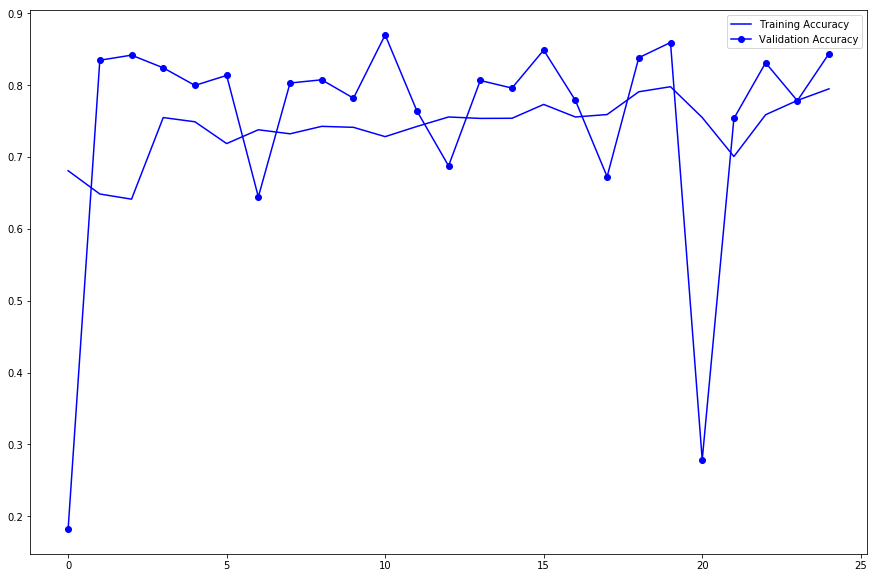

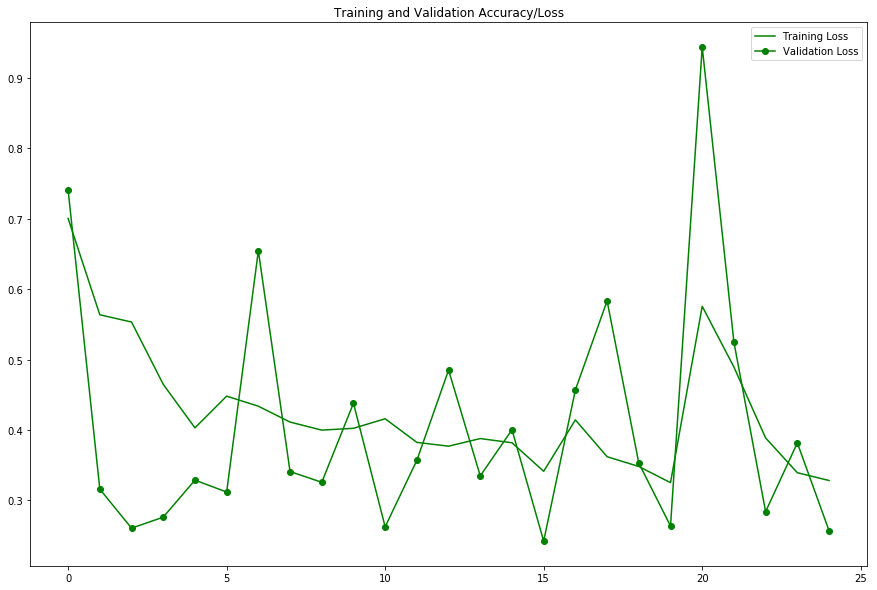

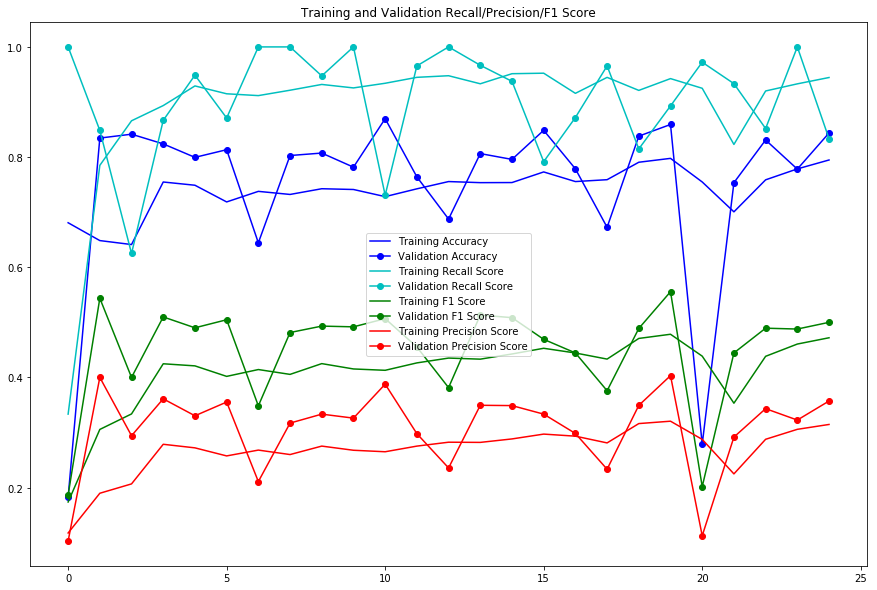

In [18]:
classification_report_graph(history1) #plotting the accuracy, loss, and classification report of each epoch

              precision    recall  f1-score   support

    low_risk       0.98      0.85      0.91      1240
 severe_risk       0.40      0.86      0.55       139

   micro avg       0.86      0.86      0.86      1379
   macro avg       0.69      0.86      0.73      1379
weighted avg       0.92      0.86      0.88      1379
 


          Normalized confusion matrix


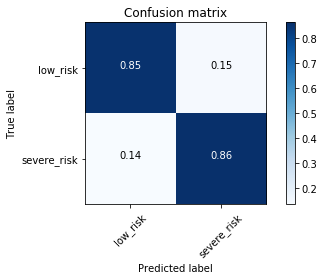

In [19]:
model_report(model1,test_generator) #printing the classification report and confusion matrix for specified weights

              precision    recall  f1-score   support

    low_risk       0.95      0.88      0.92      1240
 severe_risk       0.37      0.63      0.46       139

   micro avg       0.85      0.85      0.85      1379
   macro avg       0.66      0.75      0.69      1379
weighted avg       0.90      0.85      0.87      1379
 


          Normalized confusion matrix


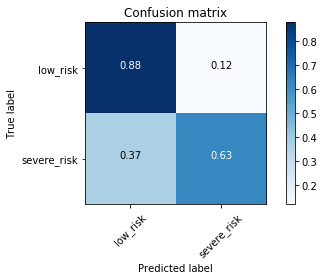

In [20]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model1, test_generator, weights='Model_1_Weights/weights.03.hdf5')

              precision    recall  f1-score   support

    low_risk       1.00      0.53      0.70      1240
 severe_risk       0.19      1.00      0.33       139

   micro avg       0.58      0.58      0.58      1379
   macro avg       0.60      0.77      0.51      1379
weighted avg       0.92      0.58      0.66      1379
 


          Normalized confusion matrix


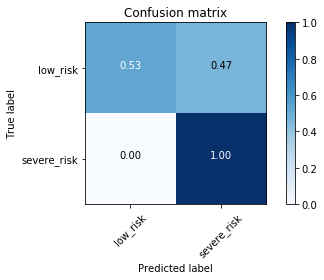

In [21]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model1, test_generator, weights='Model_1_Weights/weights.07.hdf5')

              precision    recall  f1-score   support

    low_risk       0.97      0.86      0.91      1240
 severe_risk       0.39      0.76      0.51       139

   micro avg       0.85      0.85      0.85      1379
   macro avg       0.68      0.81      0.71      1379
weighted avg       0.91      0.85      0.87      1379
 


          Normalized confusion matrix


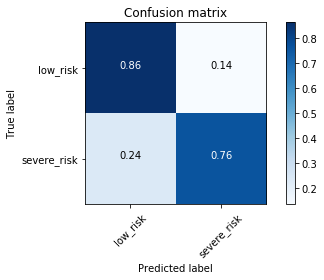

In [22]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model1, test_generator, weights='Model_1_Weights/weights.19.hdf5')

              precision    recall  f1-score   support

    low_risk       1.00      0.71      0.83      1240
 severe_risk       0.28      0.99      0.43       139

   micro avg       0.74      0.74      0.74      1379
   macro avg       0.64      0.85      0.63      1379
weighted avg       0.92      0.74      0.79      1379
 


          Normalized confusion matrix


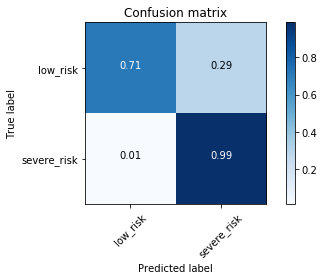

In [23]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model1, test_generator, weights='Model_1_Weights/weights.24.hdf5')

In [24]:
filepath = 'Model_1_Weights/weights.{epoch:02d}.hdf5' #saving the weights at each epoch to find/use optimal model
checkpoint = ModelCheckpoint(filepath, verbose=0, save_weights_only=True)

#compiling the model:
model1.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['acc', keras_metrics.f1_score(), keras_metrics.recall(), keras_metrics.precision()])
#running the model:
history1 = model1.fit_generator(train_generator, steps_per_epoch=40,initial_epoch=25, 
                                epochs=50, verbose=0, callbacks=[checkpoint],
                                validation_data=validation_generator, validation_steps=3,
                                class_weight=class_weights)

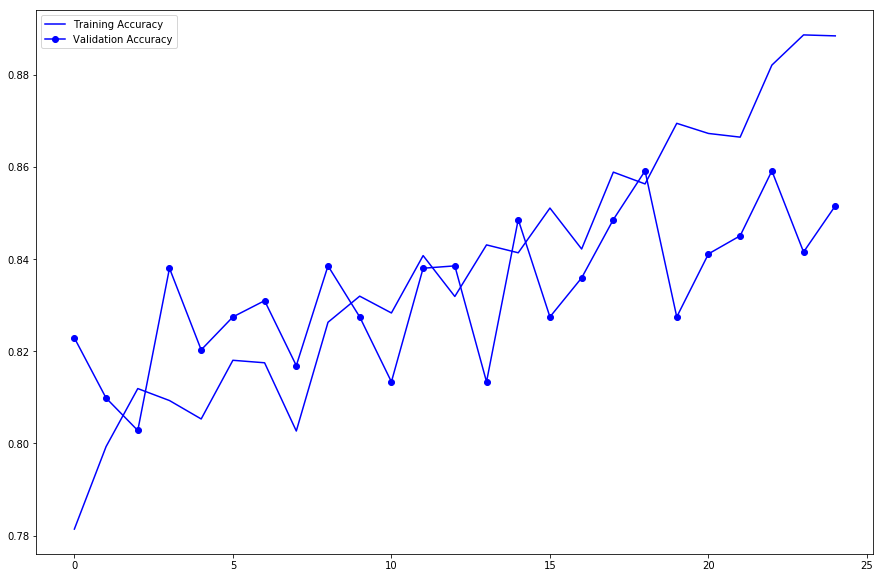

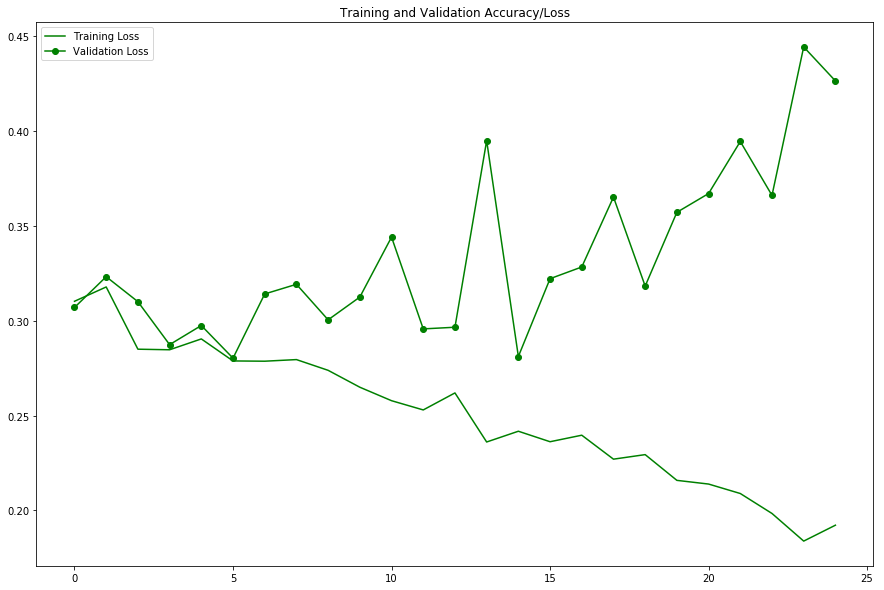

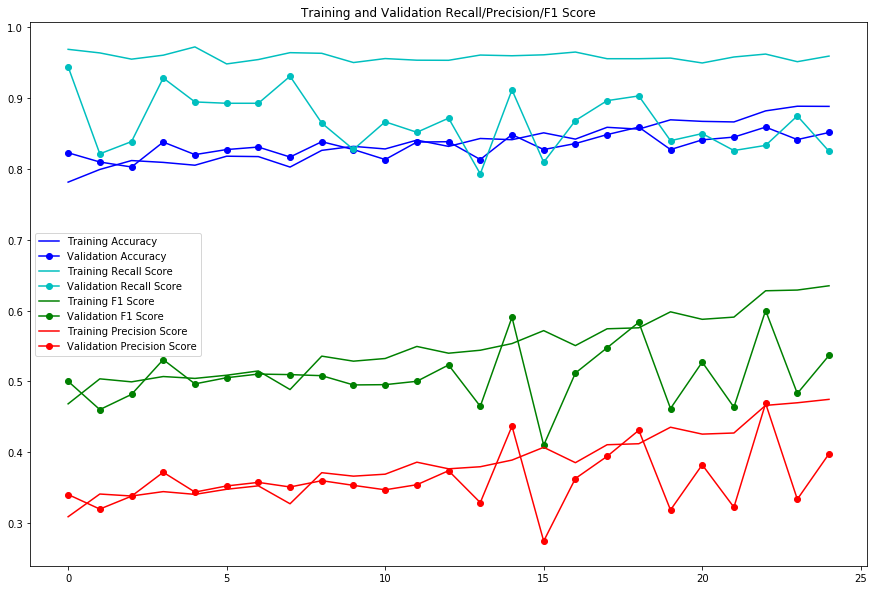

In [25]:
classification_report_graph(history1) #plotting the accuracy, loss, and classification report of each epoch

              precision    recall  f1-score   support

    low_risk       0.98      0.88      0.93      1240
 severe_risk       0.43      0.81      0.56       139

   micro avg       0.87      0.87      0.87      1379
   macro avg       0.70      0.84      0.74      1379
weighted avg       0.92      0.87      0.89      1379
 


          Normalized confusion matrix


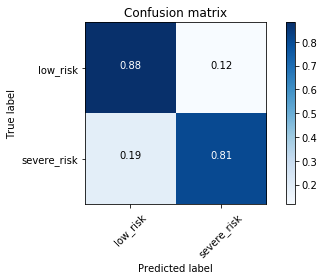

In [26]:
model_report(model1,test_generator) #printing the classification report and confusion matrix for specified weights

              precision    recall  f1-score   support

    low_risk       0.98      0.84      0.91      1240
 severe_risk       0.38      0.87      0.53       139

   micro avg       0.84      0.84      0.84      1379
   macro avg       0.68      0.86      0.72      1379
weighted avg       0.92      0.84      0.87      1379
 


          Normalized confusion matrix


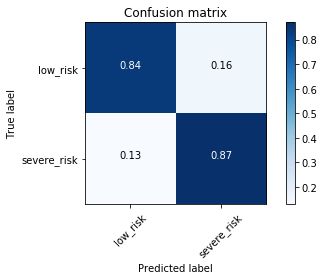

In [27]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model1, test_generator, weights='Model_1_Weights/weights.39.hdf5')

              precision    recall  f1-score   support

    low_risk       0.98      0.85      0.91      1240
 severe_risk       0.39      0.86      0.54       139

   micro avg       0.85      0.85      0.85      1379
   macro avg       0.69      0.86      0.73      1379
weighted avg       0.92      0.85      0.87      1379
 


          Normalized confusion matrix


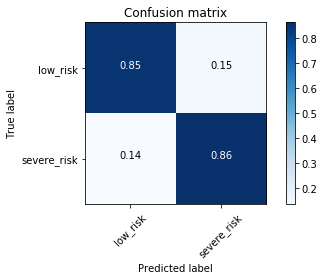

In [28]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model1, test_generator, weights='Model_1_Weights/weights.43.hdf5')

              precision    recall  f1-score   support

    low_risk       0.99      0.81      0.89      1240
 severe_risk       0.35      0.94      0.51       139

   micro avg       0.82      0.82      0.82      1379
   macro avg       0.67      0.87      0.70      1379
weighted avg       0.93      0.82      0.85      1379
 


          Normalized confusion matrix


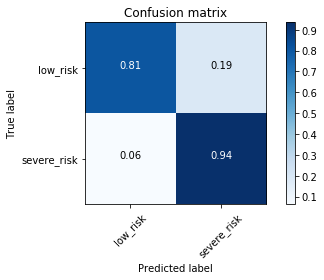

In [29]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model1, test_generator, weights='Model_1_Weights/weights.28.hdf5')

In [31]:
#utilizing the pretrained VGG16 model with a added dense layers and prediction layers to compare to previous model
base_model = keras.applications.VGG16(input_shape=(72,72,3), include_top=False, weights='imagenet')
base_model.trainable = False
maxpool = keras.layers.MaxPooling2D((2,2))
flatten = keras.layers.Flatten()
dense1 = keras.layers.Dense(512, activation='relu')
dropout1 = keras.layers.Dropout(0.25)
dense2 = keras.layers.Dense(256, activation='relu')
dropout2 = keras.layers.Dropout(0.2)
dense3 = keras.layers.Dense(128, activation='relu')
dropout3 = keras.layers.Dropout(0.15)
dense4 = keras.layers.Dense(64, activation='relu')
prediction_layer = keras.layers.Dense(1, activation='sigmoid')
#assembling the model architecture with the pretrained network:
model2 = models.Sequential([base_model,
                            maxpool,flatten,
                            dense1,dropout1,
                            dense2,dropout2,
                            dense3,dropout3,
                            dense4,prediction_layer])

model2.save('model_2.h5') #saving the model
filepath = 'Model_2_Weights/weights.{epoch:02d}.hdf5' #saving the weights at each epoch to find/use optimal model
os.mkdir('Model_2_Weights')
checkpoint = ModelCheckpoint(filepath, verbose=0, save_weights_only=True)

#compiling the model:
model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc', keras_metrics.f1_score(), keras_metrics.recall(), keras_metrics.precision()])
#running the model:
history2 = model2.fit_generator(train_generator, steps_per_epoch=40, 
                                epochs=25, verbose=0,validation_steps=3,
                                validation_data=validation_generator, 
                                class_weight=class_weights,callbacks=[checkpoint])

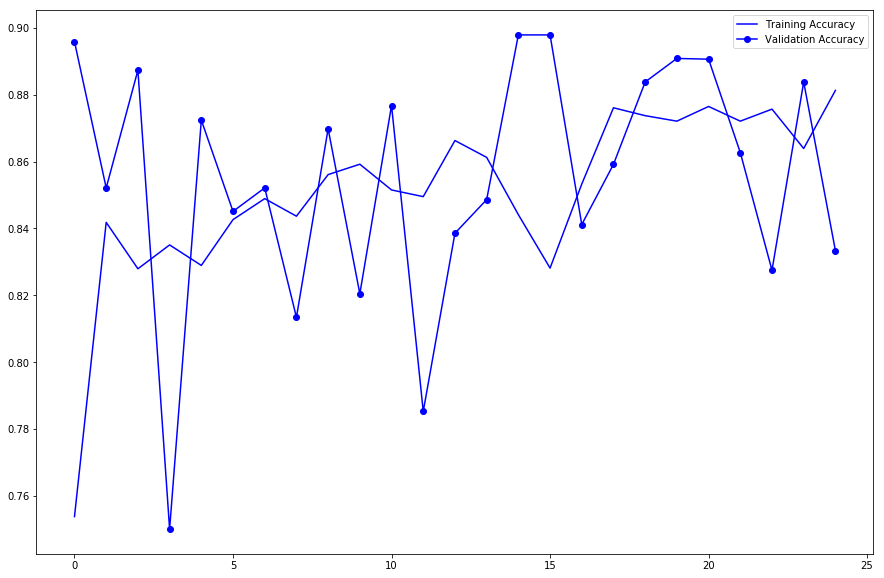

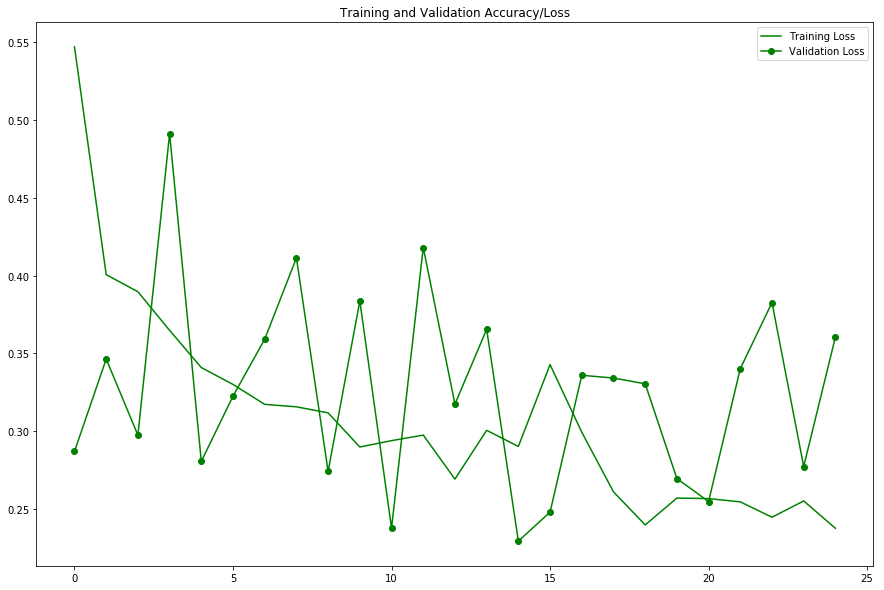

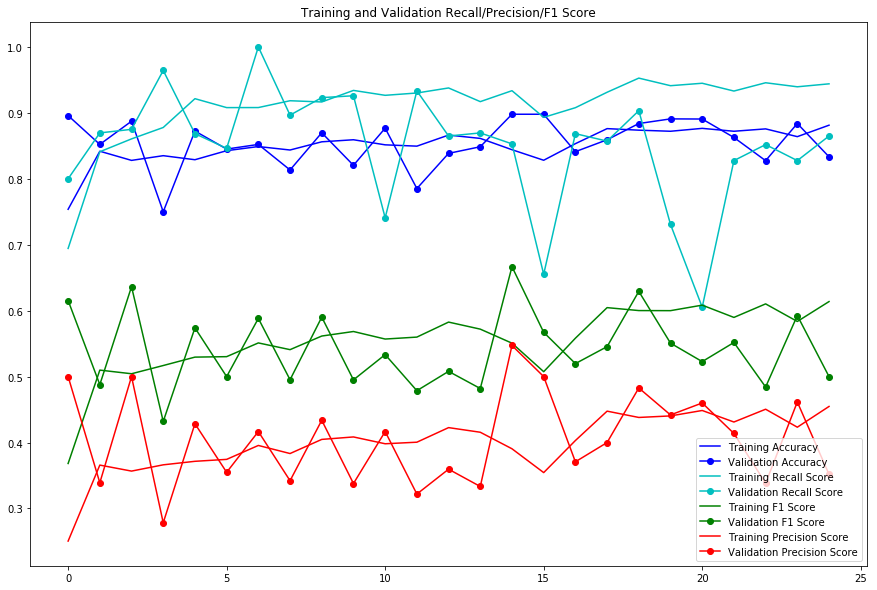

In [32]:
classification_report_graph(history2) #plotting the accuracy, loss, and classification report of each epoch

              precision    recall  f1-score   support

    low_risk       0.98      0.82      0.90      1240
 severe_risk       0.36      0.88      0.51       139

   micro avg       0.83      0.83      0.83      1379
   macro avg       0.67      0.85      0.71      1379
weighted avg       0.92      0.83      0.86      1379
 


          Normalized confusion matrix


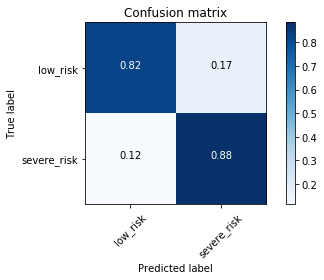

In [33]:
model_report(model2, test_generator)#printing the classification report and confusion matrix 

              precision    recall  f1-score   support

    low_risk       0.99      0.84      0.91      1240
 severe_risk       0.39      0.91      0.55       139

   micro avg       0.85      0.85      0.85      1379
   macro avg       0.69      0.88      0.73      1379
weighted avg       0.93      0.85      0.87      1379
 


          Normalized confusion matrix


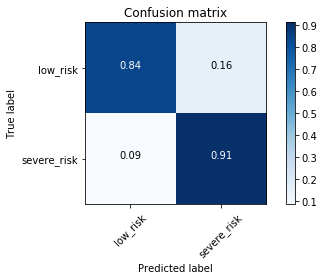

In [34]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model2, test_generator, weights='Model_2_Weights/weights.06.hdf5')

              precision    recall  f1-score   support

    low_risk       0.98      0.87      0.92      1240
 severe_risk       0.42      0.86      0.56       139

   micro avg       0.86      0.86      0.86      1379
   macro avg       0.70      0.86      0.74      1379
weighted avg       0.92      0.86      0.88      1379
 


          Normalized confusion matrix


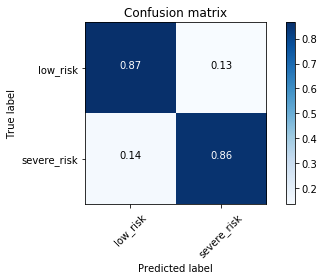

In [35]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model2, test_generator, weights='Model_2_Weights/weights.18.hdf5')

              precision    recall  f1-score   support

    low_risk       0.99      0.83      0.90      1240
 severe_risk       0.37      0.91      0.53       139

   micro avg       0.84      0.84      0.84      1379
   macro avg       0.68      0.87      0.71      1379
weighted avg       0.93      0.84      0.86      1379
 


          Normalized confusion matrix


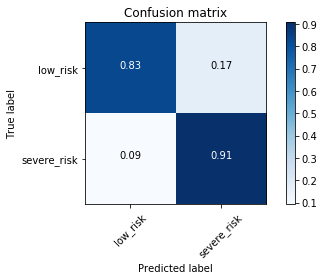

In [36]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model2, test_generator, weights='Model_2_Weights/weights.14.hdf5')

In [37]:
filepath = 'Model_2_Weights/weights.{epoch:02d}.hdf5' #saving the weights at each epoch to find/use optimal model

checkpoint = ModelCheckpoint(filepath, verbose=0, save_weights_only=True)

#compiling the model:
model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['acc', keras_metrics.f1_score(), keras_metrics.recall(), keras_metrics.precision()])

history2 = model2.fit_generator(train_generator, steps_per_epoch=40, 
                                epochs=50, verbose=0,validation_steps=3,
                                validation_data=validation_generator,initial_epoch=25, 
                                class_weight=class_weights,callbacks=[checkpoint])

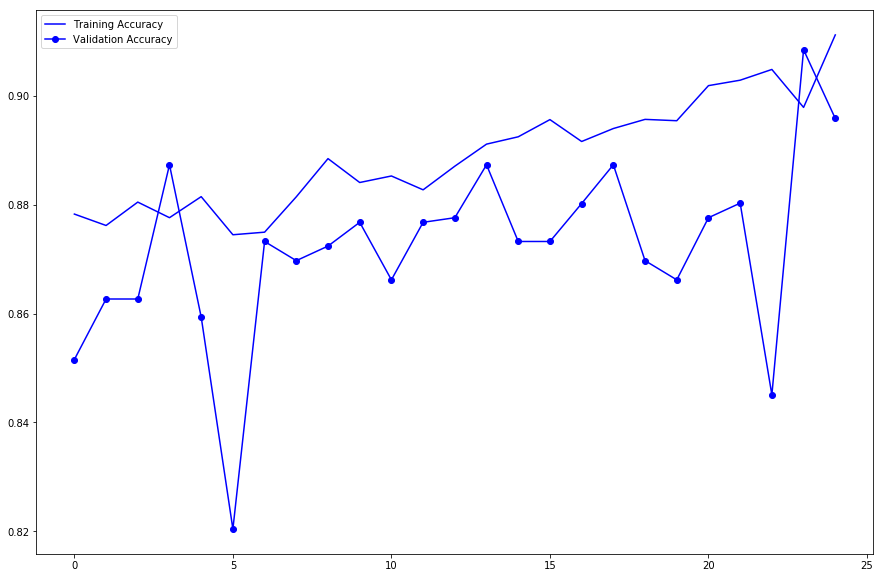

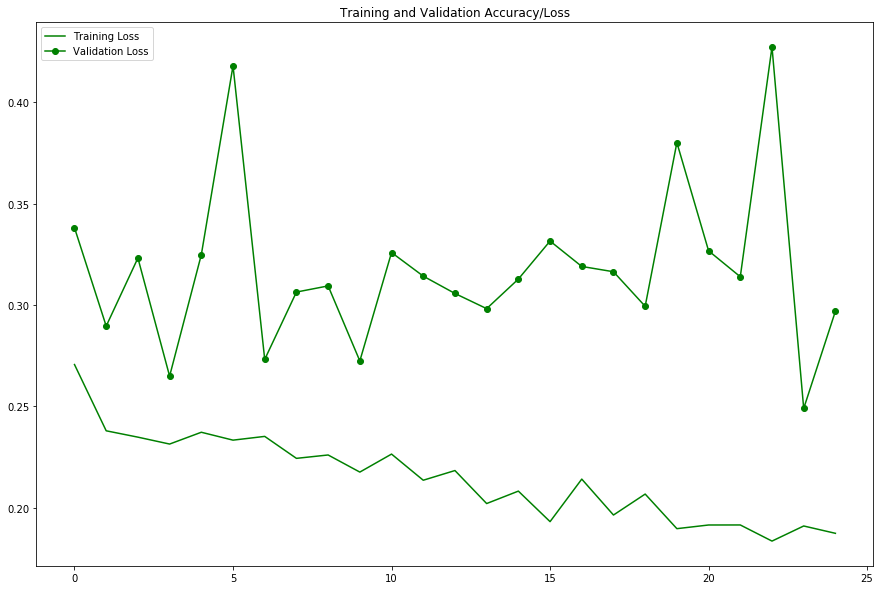

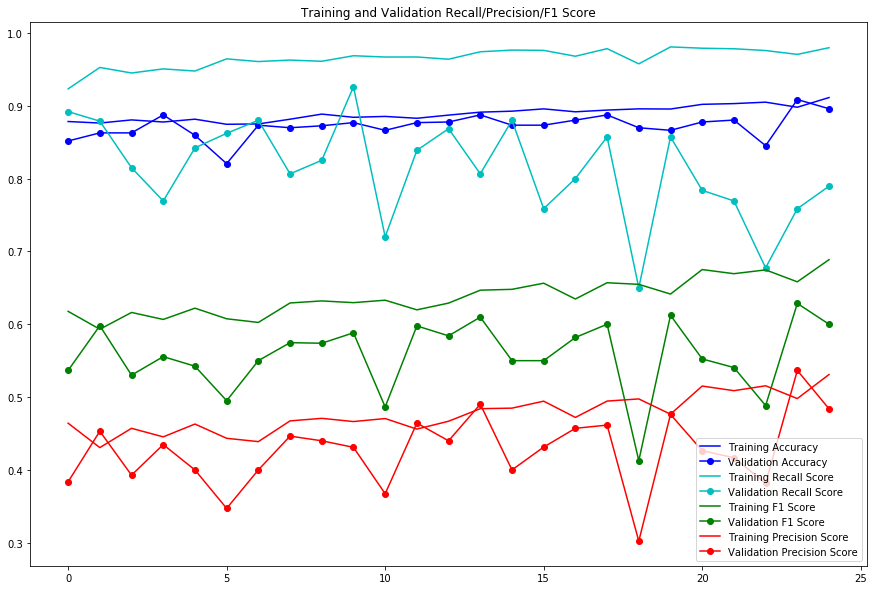

In [38]:
classification_report_graph(history2)

              precision    recall  f1-score   support

    low_risk       0.98      0.89      0.93      1240
 severe_risk       0.45      0.81      0.58       139

   micro avg       0.88      0.88      0.88      1379
   macro avg       0.72      0.85      0.76      1379
weighted avg       0.92      0.88      0.90      1379
 


          Normalized confusion matrix


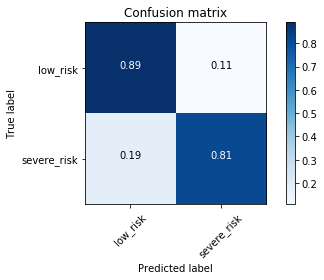

In [39]:
model_report(model2, test_generator)#printing the classification report and confusion matrix 

              precision    recall  f1-score   support

    low_risk       0.98      0.88      0.93      1240
 severe_risk       0.43      0.84      0.57       139

   micro avg       0.87      0.87      0.87      1379
   macro avg       0.71      0.86      0.75      1379
weighted avg       0.93      0.87      0.89      1379
 


          Normalized confusion matrix


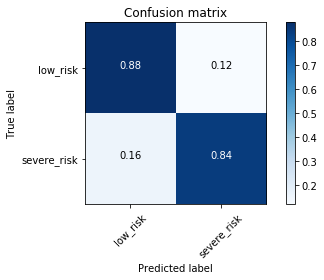

In [40]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model2, test_generator, weights='Model_2_Weights/weights.34.hdf5')

              precision    recall  f1-score   support

    low_risk       0.98      0.88      0.93      1240
 severe_risk       0.44      0.83      0.57       139

   micro avg       0.88      0.88      0.88      1379
   macro avg       0.71      0.85      0.75      1379
weighted avg       0.92      0.88      0.89      1379
 


          Normalized confusion matrix


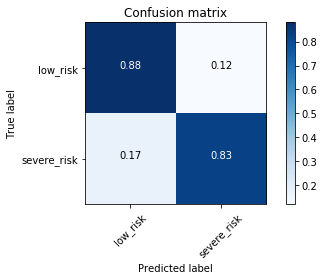

In [41]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model2, test_generator, weights='Model_2_Weights/weights.44.hdf5')

# Data Augmentation

In [42]:
#printing the current number of images in each class in the training directory to assess class imbalance:
print("current number of benign images in training directory: ", 
      len(os.listdir(
      '../Project-4-Neural-Networks-For-Skin-Cancer-Risk-Assessment/base_directory/train_directory/low_risk/')))

print("current number of malignant images in training directory: ",
      len(os.listdir(
     '../Project-4-Neural-Networks-For-Skin-Cancer-Risk-Assessment/base_directory/train_directory/severe_risk/')))
#data augmentation to address class imbalance:
to_aug = ['severe_risk', 'low_risk']

for item in to_aug:
    
    # creating temporary directories to delete later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item
    img_list = os.listdir(
        '../Project-4-Neural-Networks-For-Skin-Cancer-Risk-Assessment/base_directory/train_directory/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join(
                    '../Project-4-Neural-Networks-For-Skin-Cancer-Risk-Assessment/base_directory/train_directory/'+img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = '../Project-4-Neural-Networks-For-Skin-Cancer-Risk-Assessment/base_directory/train_directory/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=90,
        zoom_range=(0.9,1),
        brightness_range=(1,1.2))
    batch_size = 128

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(650,400),
                                                    batch_size=batch_size)

    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 5000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 4000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')
#printing the new number of images per class in the training directory after data augmentation:    
print("number of benign images in training directory: ",
      len(os.listdir(
        '../Project-4-Neural-Networks-For-Skin-Cancer-Risk-Assessment/base_directory/train_directory/low_risk/')))

print("number of malignant images in training directory after data augmentation: ",
     len(os.listdir(
     '../Project-4-Neural-Networks-For-Skin-Cancer-Risk-Assessment/base_directory/train_directory/severe_risk/')))

current number of benign images in training directory:  3718
current number of malignant images in training directory:  417
Found 417 images belonging to 1 classes.
Found 3718 images belonging to 1 classes.
number of benign images in training directory:  5126
number of malignant images in training directory after data augmentation:  4170


In [43]:
# Generating batches of tensor image data
aug_train_generator = train_datagen.flow_from_directory(train_directory, subset= "training",shuffle=True,
                                                    target_size=(72,72),batch_size=128,
                                                    class_mode='binary')

aug_validation_generator = train_datagen.flow_from_directory(train_directory, subset="validation",shuffle=True,
                                                         target_size=(72,72),batch_size=128,
                                                         class_mode='binary')

aug_test_generator = test_datagen.flow_from_directory(test_directory,target_size=(72,72),
                                                  shuffle=False,batch_size=1,
                                                  class_mode='binary')
true_classes = aug_test_generator.classes
class_labels = list(aug_test_generator.class_indices.keys()) 

Found 8367 images belonging to 2 classes.
Found 929 images belonging to 2 classes.
Found 1379 images belonging to 2 classes.


In [44]:
#assembling the model architecture
model3 = models.load_model('model_3.h5', compile=False)

class_weights= {0:0.5, 1:3}

filepath = 'Model_3_Weights/weights.{epoch:02d}.hdf5'
os.mkdir('Model_3_Weights')
checkpoint = ModelCheckpoint(filepath, verbose=0, save_weights_only=True)
#compiling the model:
model3.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc', keras_metrics.f1_score(), keras_metrics.recall(), keras_metrics.precision()])
#running the model:
history3 = model3.fit_generator(aug_train_generator, steps_per_epoch=60,class_weight=class_weights,
                                verbose=0, callbacks=[checkpoint], epochs=25,
                                validation_data=aug_validation_generator, validation_steps=6)

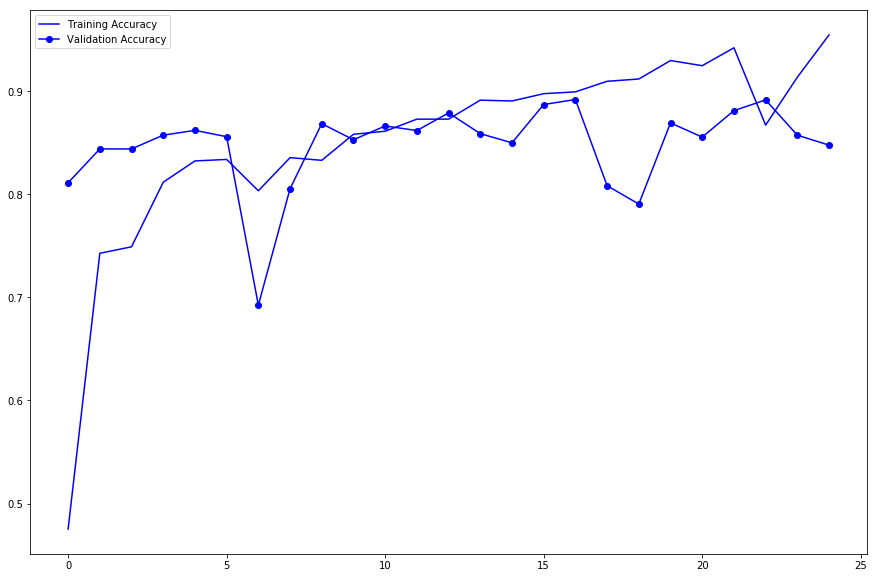

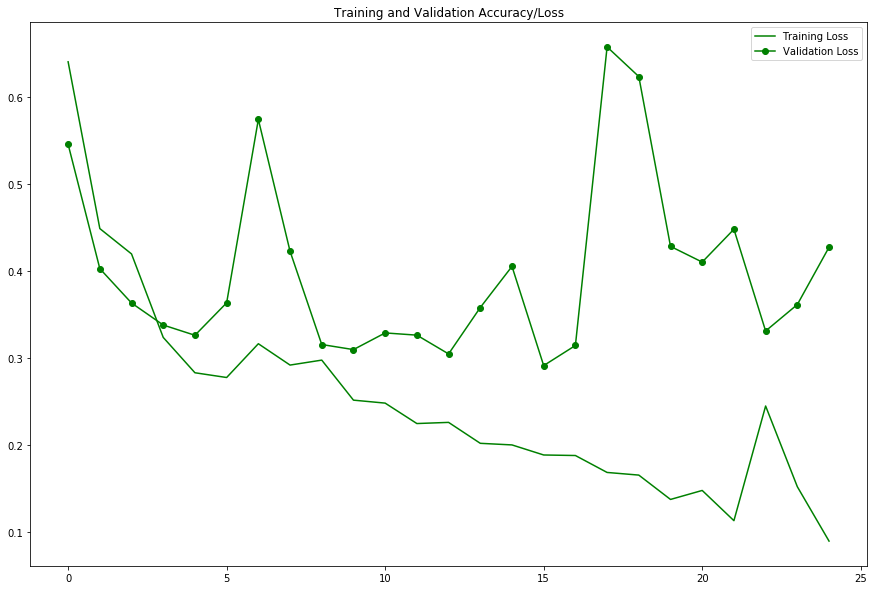

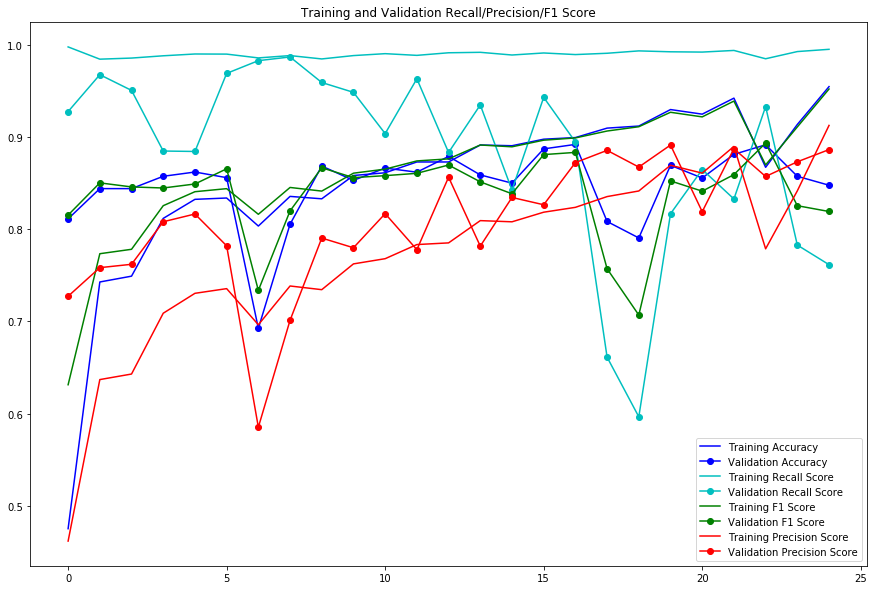

In [45]:
classification_report_graph(history3)

              precision    recall  f1-score   support

    low_risk       0.95      0.92      0.94      1240
 severe_risk       0.45      0.57      0.50       139

   micro avg       0.89      0.89      0.89      1379
   macro avg       0.70      0.75      0.72      1379
weighted avg       0.90      0.89      0.89      1379
 


          Normalized confusion matrix


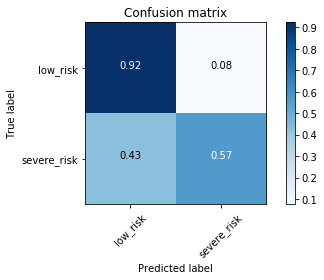

In [46]:
model_report(model3, aug_test_generator)

              precision    recall  f1-score   support

    low_risk       0.99      0.70      0.82      1240
 severe_risk       0.26      0.93      0.40       139

   micro avg       0.72      0.72      0.72      1379
   macro avg       0.62      0.81      0.61      1379
weighted avg       0.91      0.72      0.78      1379
 


          Normalized confusion matrix


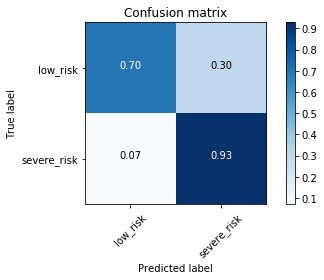

In [47]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model3, aug_test_generator, weights='Model_3_Weights/weights.01.hdf5')

              precision    recall  f1-score   support

    low_risk       0.99      0.79      0.88      1240
 severe_risk       0.34      0.94      0.50       139

   micro avg       0.81      0.81      0.81      1379
   macro avg       0.67      0.87      0.69      1379
weighted avg       0.93      0.81      0.84      1379
 


          Normalized confusion matrix


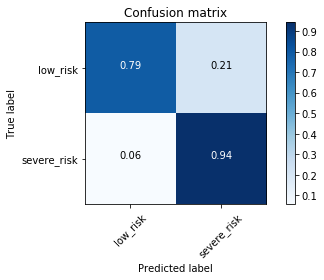

In [48]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model3, aug_test_generator, weights='Model_3_Weights/weights.09.hdf5')

              precision    recall  f1-score   support

    low_risk       1.00      0.64      0.78      1240
 severe_risk       0.24      0.99      0.38       139

   micro avg       0.68      0.68      0.68      1379
   macro avg       0.62      0.81      0.58      1379
weighted avg       0.92      0.68      0.74      1379
 


          Normalized confusion matrix


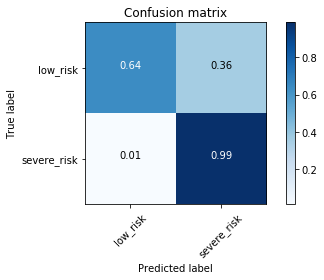

In [49]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model3, aug_test_generator, weights='Model_3_Weights/weights.08.hdf5')

              precision    recall  f1-score   support

    low_risk       0.96      0.92      0.94      1240
 severe_risk       0.46      0.64      0.53       139

   micro avg       0.89      0.89      0.89      1379
   macro avg       0.71      0.78      0.74      1379
weighted avg       0.91      0.89      0.90      1379
 


          Normalized confusion matrix


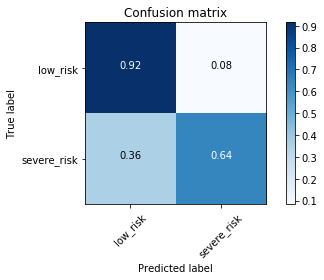

In [50]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model3, aug_test_generator, weights='Model_3_Weights/weights.22.hdf5')

In [51]:
filepath = 'Model_3_Weights/weights.{epoch:02d}.hdf5'

checkpoint = ModelCheckpoint(filepath, verbose=0, save_weights_only=True)
#compiling the model:
model3.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['acc', keras_metrics.f1_score(), keras_metrics.recall(), keras_metrics.precision()])
#running the model:
history4 = model3.fit_generator(aug_train_generator, steps_per_epoch=55, epochs=50,initial_epoch=25,
                                verbose=0, callbacks=[checkpoint], class_weight = class_weights,
                                validation_data=aug_validation_generator, validation_steps=6)

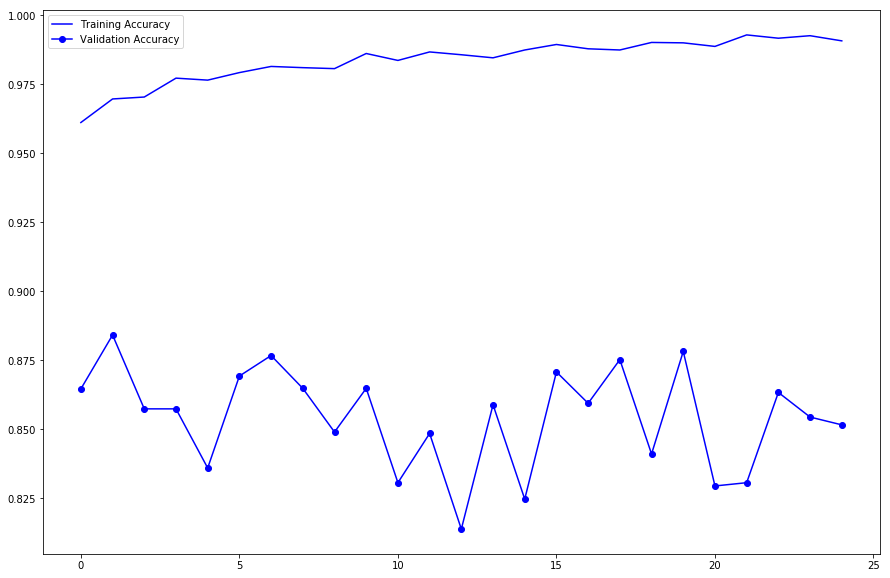

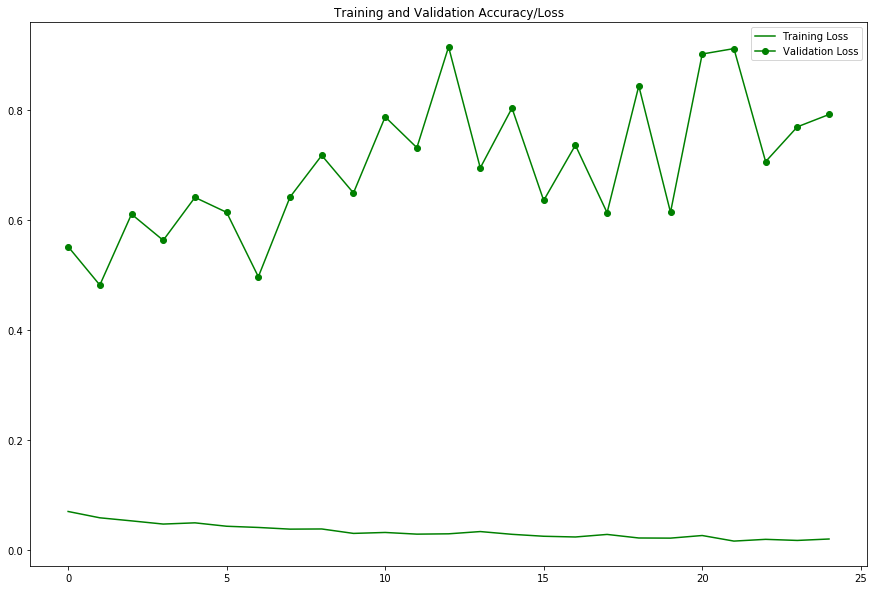

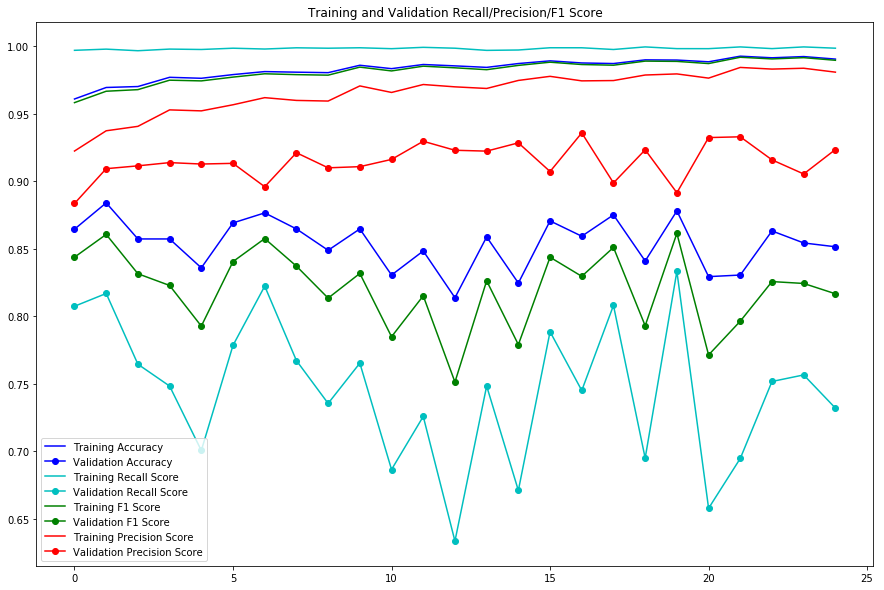

In [52]:
classification_report_graph(history4)

              precision    recall  f1-score   support

    low_risk       0.94      0.94      0.94      1240
 severe_risk       0.49      0.51      0.50       139

   micro avg       0.90      0.90      0.90      1379
   macro avg       0.72      0.73      0.72      1379
weighted avg       0.90      0.90      0.90      1379
 


          Normalized confusion matrix


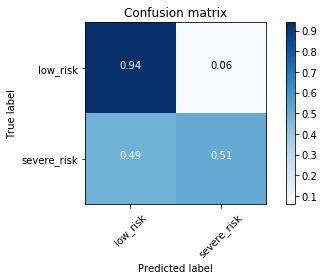

In [53]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model3, aug_test_generator)

              precision    recall  f1-score   support

    low_risk       0.94      0.94      0.94      1240
 severe_risk       0.49      0.47      0.48       139

   micro avg       0.90      0.90      0.90      1379
   macro avg       0.71      0.71      0.71      1379
weighted avg       0.89      0.90      0.90      1379
 


          Normalized confusion matrix


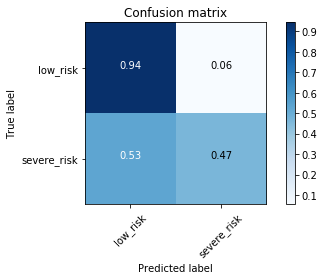

In [54]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model3, aug_test_generator, weights='Model_3_Weights/weights.19.hdf5')

              precision    recall  f1-score   support

    low_risk       0.93      0.94      0.94      1240
 severe_risk       0.44      0.41      0.42       139

   micro avg       0.89      0.89      0.89      1379
   macro avg       0.69      0.68      0.68      1379
weighted avg       0.88      0.89      0.89      1379
 


          Normalized confusion matrix


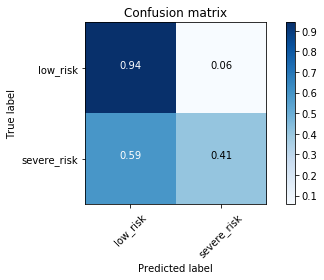

In [57]:
#assessing the classification report and confusion matrix with loaded weights from a chosen epoch
model_report(model3, aug_test_generator, weights='Model_3_Weights/weights.38.hdf5')

<a id='Part_5'></a>

# Final Model

              precision    recall  f1-score   support

    low_risk       0.99      0.81      0.89      1240
 severe_risk       0.35      0.94      0.51       139

   micro avg       0.82      0.82      0.82      1379
   macro avg       0.67      0.87      0.70      1379
weighted avg       0.93      0.82      0.85      1379
 


          Normalized confusion matrix


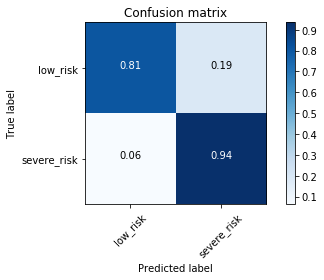

In [68]:
#best performing model and best weights:
model_report(model1, test_generator, weights='Model_1_Weights/weights.28.hdf5')

     Confusion matrix, without normalization


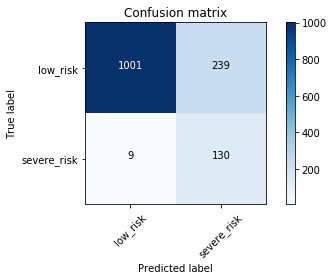

In [69]:
model1.load_weights('Model_1_Weights/weights.28.hdf5')
predictions= model1.predict_classes(test_generator, batch_size=None)
cm= confusion_matrix(test_generator.classes, predictions)
plot_confusion_matrix(cm, list(test_generator.class_indices.keys()), normalize=False)

In [70]:
model1.save_weights('Model_1_Weights/weights.28.hdf5')
Final_Model = model1

<a id='Part_6'></a>

# Conclusions

#### 1. Overall Statistics:
    * Accuracy: 82%
    * Precision: 83%
    * Recall: 94%
    * F1 Score: 88%
    
    

#### 2. Pretrained Networks did not perform as well as the custom model created from scratch
#### 3. Data Augmentation did not improve the model performance as much as using the original image data alone and utilizing class weights during training


<a id='Part_7'></a>

# Recommendations & Future Work

#### 1. Examine images that were mis-classified as benign and were actually high risk with clinicians present: 
    *How can this be avoided? 
    *What are unique about these images if anything? 
    *Improve model architecture/hyperparameters based on feedback
#### 2. Continue to improve model by tuning hyperparameters with a goal of minimizing false negatives to zero.
#### 3. Continue to add data to improve model performance, especially important to add high risk images to this imbalanced dataset.
#### 4. Construct a mobile app that captures images in real time for patient convenience and test performance 